# Improving the model with a LJ baseline

In the previous notebook, we saw that our initial model was not very stable. One
possible improvement would be to add a Lennard-Jones potential as a baseline,
ensuring the model is repulsive at short distances.

In [1]:
from typing import List, Dict, Optional
import math

import torch

torch.manual_seed(123456)

import numpy as np
import matplotlib.pyplot as plt
import ase.io

from metatensor.torch import Labels, TensorBlock, TensorMap
import metatensor.torch as mts

from metatomic.torch import System, systems_to_torch
from metatomic.torch import NeighborListOptions
from metatomic.torch import ModelCapabilities, ModelMetadata, ModelOutput
from metatomic.torch import AtomisticModel
from metatomic.torch.ase_calculator import MetatomicCalculator


## Defining a Lennard-Jones energy module

The Lennard-Jones potential is a classical potential with the following functional form:

$$
E = \sum_{ij} 4 \varepsilon \left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right]
$$

Where the sum runs over all pairs in the system with a distance below the cutoff radius $r_c$.

Using the formula above directly however comes with discontinuity issues: as the
atoms enter and leave the cutoff, there is a jump and discontinuity in energies.
One solution is to shift the energy to 0 at the cutoff, leaving only a small
discontinuity in the forces.

$$
E = \sum_{ij} 4 \varepsilon \left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right] - 4 \varepsilon \left[\left(\frac{\sigma}{r_c}\right)^{12} - \left(\frac{\sigma}{r_c}\right)^6\right]
$$

To be able to compute the Lennard-Jones energy of a system, we need a list of
all pairs within the cutoff distance. Ideally, we want to get such list of pairs
directly from the MD engine, which can use some tricks for a faster
re-calculation of the list. 

In metatomic models, neighbor lists are encoded within them, and so we can directly request neighbor lists with a `requested_neighbors_lists()` function, and then accessing these neighbors lists in the `forward()` function.


| ![TASK](../img/clipboard.png) | Modify the code below to compute the LJ energy at the cutoff and `e_ij` in the loop over pairs |
|----------------------------|------------------------------------------------------------------------------------------------|

In [16]:
class LennardJones(torch.nn.Module):
    def __init__(self, cutoff, parameters: Dict[int, Dict[str, float]]):
        super().__init__()
        self.cutoff = float(cutoff)

        # The neighbors list request we are making:
        self._neighbors = NeighborListOptions(cutoff=self.cutoff, full_list=False, strict=True)

        self._lj_params = {}
        for type_i, parameters_i in parameters.items():
            sigma_i = parameters_i["sigma"]
            epsilon_i = parameters_i["epsilon"]
            self._lj_params[type_i] = {}

            for type_j, parameters_j in parameters.items():
                sigma_j = parameters_j["sigma"]
                epsilon_j = parameters_j["epsilon"]

                # combine parameters with Lorentz-Berthelot mixing rules
                sigma = (sigma_i + sigma_j) / 2
                epsilon = math.sqrt(epsilon_i * epsilon_j)

                # compute the energy at the cutoff for these parameters, to remove it
                # from the energy of a pair in forward

                # TODO: update here
                s_r = sigma / self.cutoff
                energy_at_cutoff = 4 * epsilon * (s_r**12 - s_r**6)

                self._lj_params[type_i][type_j] = [sigma, epsilon, energy_at_cutoff]

    # expose the requested neighbor list so metatomic can find it
    def requested_neighbor_lists(self) -> List[NeighborListOptions]:
        return [self._neighbors]

    def forward(
        self,
        systems: List[System],
        outputs: Dict[str, ModelOutput],
        selected_atoms: Optional[Labels] = None,
    ) -> Dict[str, TensorMap]:
        if "energy" not in outputs:
            return {}

        total_energy = torch.zeros(len(systems), dtype=systems[0].positions.dtype)
        for i_system, system in enumerate(systems):
            # The neighbor list was computed by the MD engine and
            # is available as a TensorBlock
            neighbors = system.get_neighbor_list(self._neighbors)
            # the samples of this block are
            #     first_atom   second_atom   cell_shift_a   cell_shift_b   cell_shift_c
            all_i = neighbors.samples.column("first_atom")
            all_j = neighbors.samples.column("second_atom")
    
            # system also contains `positions`, `cell` and `types`, 
            # here we'll need types to get the correct LJ parameters
            types = system.types
    
            # loop over all pairs
            for i_pair, (atom_i, atom_j) in enumerate(zip(all_i, all_j)):
                if selected_atoms is not None:
                    # skip non-selected atoms
                    atom_i_selected = [i_system, int(atom_i)] in selected_atoms
                    atom_j_selected = [i_system, int(atom_j)] in selected_atoms
                    if not atom_i_selected and not atom_j_selected:
                        continue
                
                # get the parameters for the current pair of species
                type_i = int(types[atom_i])
                type_j = int(types[atom_j])
                sigma, epsilon, shift = self._lj_params[type_i][type_j]
                # get the distance between the two atoms
                distance = neighbors.values[i_pair].reshape(3)
    
                # square of the distance between the atoms
                r2 = distance.dot(distance)
    
                # TODO: update here
                s_r_2 = sigma**2 / r2
                e_ij = 4 * epsilon * (s_r_2**6 - s_r_2**3)
    
                total_energy[i_system] += e_ij - shift

        # as previously, return a Dict of TensorMap containing the energy
        block = TensorBlock(
            values=total_energy.reshape(1, 1),
            samples=Labels(["_"], torch.IntTensor([[0]])),
            components=[],
            properties=Labels(["energy"], torch.IntTensor([[0]])),
        )
        return {
            "energy": TensorMap(Labels(["energy"], torch.tensor([[0]])), blocks=[block])
        }


In [17]:
# energies in eV and distances in Angstroms
LJ_PARAMETERS = {
    1: {"sigma": 2.32, "epsilon": 3.3104e-6},
    6: {"sigma": 2.94, "epsilon": 2.3309e-6},
    8: {"sigma": 2.66, "epsilon": 2.4673e-6},
}
LJ_CUTOFF = 6.0

lj = LennardJones(cutoff=LJ_CUTOFF, parameters=LJ_PARAMETERS)
lj = lj.eval()


In [18]:
# Read the data
frames = ase.io.read("../propenol_conformers_dftb.xyz", ":500")


Now that we have a custom Lennard-Jones implementation, we can use the same  facilities to export it as a `AtomisticModule` and use it in ASE.

In [19]:
capabilities = ModelCapabilities(
    length_unit="angstrom",
    atomic_types=[1, 6, 8],
    interaction_range=LJ_CUTOFF,
    dtype="float64",
    supported_devices=["cpu"],
    outputs={
        "energy": ModelOutput(
            quantity="energy",
            unit="eV",
            per_atom=False,
        ),
    },
)

# when using `MetatomicCalculator`, the neighbors lists are provided by ASE.
#
# notice that we don't need to export the model to a file to be able to use it with ASE.
ase_calculator = MetatomicCalculator(AtomisticModel(lj, ModelMetadata(), capabilities))


We'll start by checking that the code runs and produces a reasonable output.

In [20]:
# check that the code runs fine on the first frame
atoms = frames[0]
atoms.calc = ase_calculator

energy = atoms.get_potential_energy()
if abs(energy - 3.05) > 0.1:
    raise Exception(f"the energy seems wrong: {energy}")


Now, we can modify our training set to remove the part accounted for by the LJ module

In [21]:
energies = []
forces = []

# remove the LJ energies and forces from the targets
for atoms in frames:
    atoms.calc = ase_calculator
    energies.append(atoms.info["dftb_energy_eV"] - atoms.get_potential_energy())
    forces.append(atoms.arrays["dftb_forces_eV_per_Ang"] - atoms.get_forces())

energies = np.vstack(energies)
forces = np.vstack(forces)


## Training the NN, again!

Let's re-define our model, and re-train it on the new targets!

In [22]:
from featomic.torch import SoapPowerSpectrum

In [23]:
# this is the same definition as in notebook 2

class SOAPModel(torch.nn.Module):
    def __init__(self, soap_parameters, atomic_types, energy_offset):
        super().__init__()

        self.energy_offset = torch.tensor(energy_offset)
        self.atomic_types = atomic_types

        self.soap_calculator = SoapPowerSpectrum(**soap_parameters)
        self.neighbor_atom_types = Labels(
            ["neighbor_1_type", "neighbor_2_type"], 
            torch.tensor([(i, j) for i in atomic_types for j in atomic_types if i <= j])
        )

        # Number of features produced by the SOAP calculator,
        # i.e. size of the input of the NN
        n_soap = (
            (soap_parameters["basis"]["max_angular"] + 1)
            * (soap_parameters["basis"]["radial"]["max_radial"] + 1) ** 2
            * len(self.neighbor_atom_types)
        )

    
        # we are using utilities from `metatensor-learn` to define the NN in a metatensor-compatible way
        # https://docs.metatensor.org/latest/learn/reference/nn/index.html#metatensor.learn.nn.ModuleMap
        self.soap_nn = mts.learn.nn.ModuleMap(
            in_keys = Labels("_", torch.tensor([[0]])),
            modules = [torch.nn.Sequential(
                # Definition of our NN: one hidden layer,
                # SiLU activation, 128-sized latent space
                torch.nn.Linear(
                    in_features=n_soap, out_features=128, bias=False, dtype=torch.float64
                ),
                torch.nn.SiLU(),
                torch.nn.Linear(
                    in_features=128, out_features=128, bias=False, dtype=torch.float64
                ),
                torch.nn.SiLU(),
                torch.nn.Linear(
                    in_features=128, out_features=1, bias=True, dtype=torch.float64
                ),
            )]
        )

    def forward(
        self,
        systems: List[System],
        selected_atoms: Optional[Labels] = None,
    ) -> torch.Tensor:        
        soap = self.soap_calculator(systems, selected_samples=selected_atoms)
        soap = soap.keys_to_properties(self.neighbor_atom_types)
        soap = soap.keys_to_samples("center_type")

        energies_per_atom = self.soap_nn(soap)
        energy = mts.sum_over_samples(energies_per_atom, ["atom", "center_type"])
        energy = energy.block().values

        return energy + self.energy_offset


In [24]:
SOAP_PARAMETERS = {
    "cutoff": {
        "radius": 3.5,
        "smoothing": {
            "type": "ShiftedCosine",
            "width": 0.2
        }
    },
    "density": {
        "type": "Gaussian",
        "width": 0.3
    },
    "basis": {
        "type": "TensorProduct",
        "max_angular": 5,
        "radial": {
            "type": "Gto",
            "max_radial": 5
        }
    }
}

model = SOAPModel(
    SOAP_PARAMETERS,
    atomic_types=[1, 6, 8],
    energy_offset=energies.mean(),
)


In [25]:
systems = systems_to_torch(frames, dtype=torch.float64)

reference = torch.tensor(energies)

mse_loss = torch.nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
epoch = -1


The training procedure will be very similar to the previous one.

| ![TASK](../img/clipboard.png) | Run the training loop until the loss is below 0.1 |
|----------------------------|---------------------------------------------------|

In [26]:
start = epoch + 1

for epoch in range(start, start + 50):
    optimizer.zero_grad()
    prediction = model(systems)
    loss = mse_loss(prediction, reference)
    print(f"loss at epoch {epoch} is", loss.item())

    loss.backward()
    optimizer.step()


loss at epoch 0 is 1.461385514584309
loss at epoch 1 is 1.2953590280652136
loss at epoch 2 is 1.3306132928476653
loss at epoch 3 is 1.3112244716811388
loss at epoch 4 is 1.2252328564069392
loss at epoch 5 is 1.2367541788085519
loss at epoch 6 is 1.186010085411625
loss at epoch 7 is 1.1418613190805604
loss at epoch 8 is 1.1106433704385317
loss at epoch 9 is 1.0184096054320326
loss at epoch 10 is 0.9743260839734005
loss at epoch 11 is 0.8298123475775956
loss at epoch 12 is 0.7468624335143309
loss at epoch 13 is 0.598663333746767
loss at epoch 14 is 0.41128652991231607
loss at epoch 15 is 0.31858838592825234
loss at epoch 16 is 0.5617641701323225
loss at epoch 17 is 0.5984960737580548
loss at epoch 18 is 0.14165328383135314
loss at epoch 19 is 0.6148902860462605
loss at epoch 20 is 0.1488767175328502
loss at epoch 21 is 0.5124938961441873
loss at epoch 22 is 0.12855997225081886
loss at epoch 23 is 0.4056955144535341
loss at epoch 24 is 0.14210140964571008
loss at epoch 25 is 0.23188535046

In [27]:
if loss.item() > 0.1:
    raise Exception(
        f"loss is still too high, please continue running the training loop"
    )


We can check the output against the reference (without the LJ contributions)

Text(0, 0.5, 'predicted')

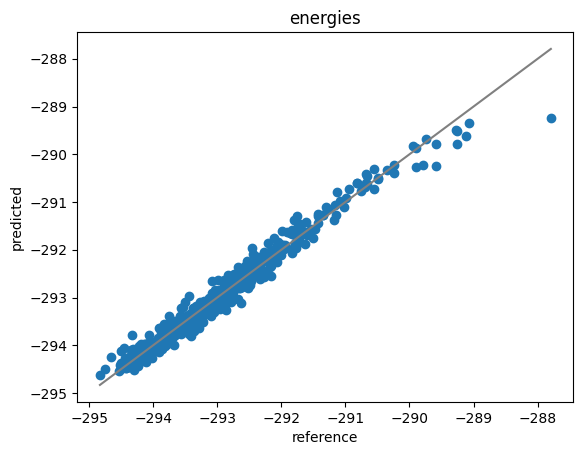

In [28]:
predicted_energy = model(systems)

plt.scatter(energies, predicted_energy.detach().numpy())

x = [np.min(energies), np.max(energies)]
plt.plot(x, x, c="grey")

plt.title("energies")
plt.xlabel("reference")
plt.ylabel("predicted")


## Re-assemble the full model

We can now assemble a new model using both the LJ contributions and the
re-trained SOAP neural network. We'll run both here, and add their outputs.

In [29]:
class ExportWrapper(torch.nn.Module):
    def __init__(self, lj, nn_model):
        super().__init__()
        self.lj = lj
        self.nn_model = nn_model

    def forward(
        self, 
        systems: List[System], 
        outputs: Dict[str, ModelOutput], 
        selected_atoms: Optional[Labels]
    ) -> Dict[str, TensorMap]:
        # check if the energy was even required
        if "energy" not in outputs:
            return {}
        
        # Run the LJ model
        outputs = self.lj(systems, outputs, selected_atoms)
        lj_energy = outputs["energy"].block().values

        # Run the NN model
        nn_energy = self.nn_model(systems, selected_atoms)

        energy = lj_energy + nn_energy

        # create the output TensorMap
        block = TensorBlock(
            values=energy.reshape(-1, 1),
            samples=Labels("system", torch.arange(len(systems)).reshape(-1, 1)),
            components=[],
            properties=Labels("energy", torch.tensor([[0]])),
        )
        
        return {
            "energy": TensorMap(keys=Labels("_", torch.tensor([[0]])), blocks=[block])
        }


With this done, we can define the capabilities of our new model, and export it to a file

In [30]:
energy_output = ModelOutput(
    quantity="energy",
    unit="eV",
    per_atom=False,
)

capabilities = ModelCapabilities(
    length_unit="angstrom",
    # the interaction_range is the largest cutoff
    interaction_range=max(SOAP_PARAMETERS["cutoff"]["radius"], LJ_CUTOFF),
    atomic_types=[1, 6, 8],
    supported_devices=["cpu"],
    dtype = "float64",
    outputs={
        "energy": energy_output,
    },
)

metadata = ModelMetadata(
    name="LJ + SOAP NN model",
    description="...",
    authors=[],
    references={
        "implementation": [],
        "architecture": [],
        "model": [],
    }
)

wrapper = ExportWrapper(lj, model).eval()
metatomic_model = AtomisticModel(wrapper, metadata, capabilities)
metatomic_model.save("propenol-model-with-lj.pt", collect_extensions="extensions")


## Running some MD with our new model

Let's see if these changes have made a difference to the stability of the model.

In [31]:
import ase.md
import ase.units

import chemiscope


In [32]:
# Using the same initial setup for the simulation

atoms = frames[0]
atoms.calc = MetatomicCalculator("propenol-model-with-lj.pt")

integrator = ase.md.VelocityVerlet(atoms, timestep=1 * ase.units.fs)


In [33]:
trajectory = [atoms.copy()]

for _ in range(200):
    integrator.run(1)
    trajectory.append(atoms.copy())


In [34]:
chemiscope.show(
    trajectory, mode="structure", settings={"structure": [{"playbackDelay": 50}]}
)


<StructureWidget(meta={'name': ' '}, settings={'structure': [{'playbackDelay': 50}]}, structures=[{'size': 10,…

We have fixed the issue of atoms getting way too close to one another! 🎉

Very obviously though, we still have other problems, from the fairly low 
accuracy to the molecule nowdecomposing into individual atoms. There would be
a handful of approaches to improve on this point (see at the end of notebook
3-ASE-md). If you have some time, feel free to go back to the model definition
and training and improve on these points!

For now, we'll see how we can take the exact same potential we just use in ASE
and use it in a completely different simulation engine: LAMMPS.